# Signature Distributions

In [5]:
import os
from collections import Counter

import dask.dataframe as dd
from matplotlib import pyplot as plt
from web3 import Web3

from graph_reinforcement_learning_using_blockchain_data import config

config.load_dotenv()

True

In [2]:
ALCHEMY_API_URL = os.getenv("ALCHEMY_API_URL")
web3 = Web3(Web3.HTTPProvider(ALCHEMY_API_URL))

In [3]:
def parse_logs(s: str):
    safe_globals = {
        "__builtins__": {},
        "AttributeDict": lambda d: d,  # return the dict directly
        "HexBytes": lambda x: x,  # return the string argument
    }
    try:
        return eval(s, safe_globals)
    except Exception as e:
        print("Error parsing logs:", e)
        return []

## Flashbots Arbitrages

In [4]:
dd_arbs = dd.read_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "arbitrages_with_logs.csv",
    dtype={
        "end_amount": "object",
        "error": "object",
        "profit_amount": "object",
        "start_amount": "object",
    },
)
dd_arbs["logs"] = dd_arbs["logs"].apply(parse_logs, meta=("logs", "object"))

In [39]:
len(dd_arbs)

113559

In [7]:
def extract_signature_distribution(logs):
    signatures = []
    for log in logs:
        if isinstance(log, dict):
            topics = log.get("topics", [])
        elif hasattr(log, "topics"):
            topics = log.topics
        else:
            topics = []

        if topics and len(topics) > 0:
            sig = topics[0]
            sig_str = sig.hex() if hasattr(sig, "hex") else str(sig)
            signatures.append(sig_str)

    return Counter(signatures)

In [9]:
signature_distribution = dd_arbs["logs"].apply(
    extract_signature_distribution, meta=("signature_distribution", "object")
)
signature_distribution = signature_distribution.compute()

In [16]:
combined_counter = Counter()
for cnt in signature_distribution:
    combined_counter.update(cnt)

In [25]:
print(type(combined_counter))

<class 'collections.Counter'>


In [30]:
def plot_signature_distribution(distribution):
    signatures = list(distribution.keys())
    counts = list(distribution.values())

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(signatures)), counts, color="skyblue")
    plt.xticks(range(len(signatures)), signatures, rotation=90)
    plt.xlabel("Signature")
    plt.ylabel("Count")
    plt.yscale("log")
    plt.title("Signature Distribution")
    plt.tight_layout()
    plt.show()

/var/folders/zd/5rj11nhj5h98j5kmp_lp5k5w0000gn/T/ipykernel_29418/214467106.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


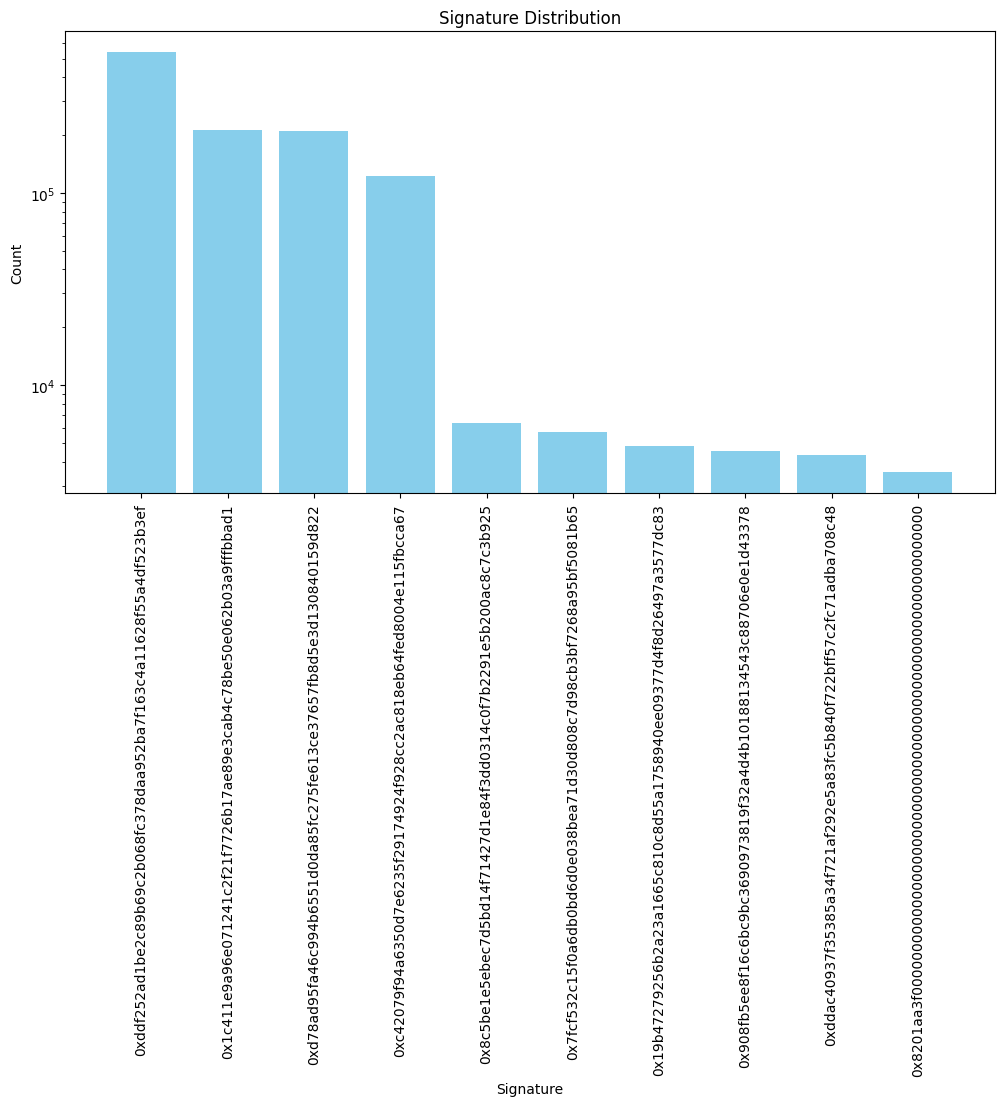

In [31]:
top_signatures = dict(combined_counter.most_common(10))
plot_signature_distribution(top_signatures)

## Normal Transactions

In [33]:
dd_normal = dd.read_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "class0_with_receipts.csv"
)
dd_normal["receipt"] = dd_normal["receipt"].apply(parse_logs, meta=("logs", "object"))
dd_normal["logs"] = dd_normal["receipt"].apply(lambda x: x["logs"], meta=("logs", "object"))

In [38]:
len(dd_normal)

114939

In [35]:
normal_signature_distribution = dd_normal["logs"].apply(
    extract_signature_distribution, meta=("signature_distribution", "object")
)
normal_signature_distribution = normal_signature_distribution.compute()

In [36]:
normal_combined_counter = Counter()
for cnt in normal_signature_distribution:
    normal_combined_counter.update(cnt)

/var/folders/zd/5rj11nhj5h98j5kmp_lp5k5w0000gn/T/ipykernel_29418/214467106.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


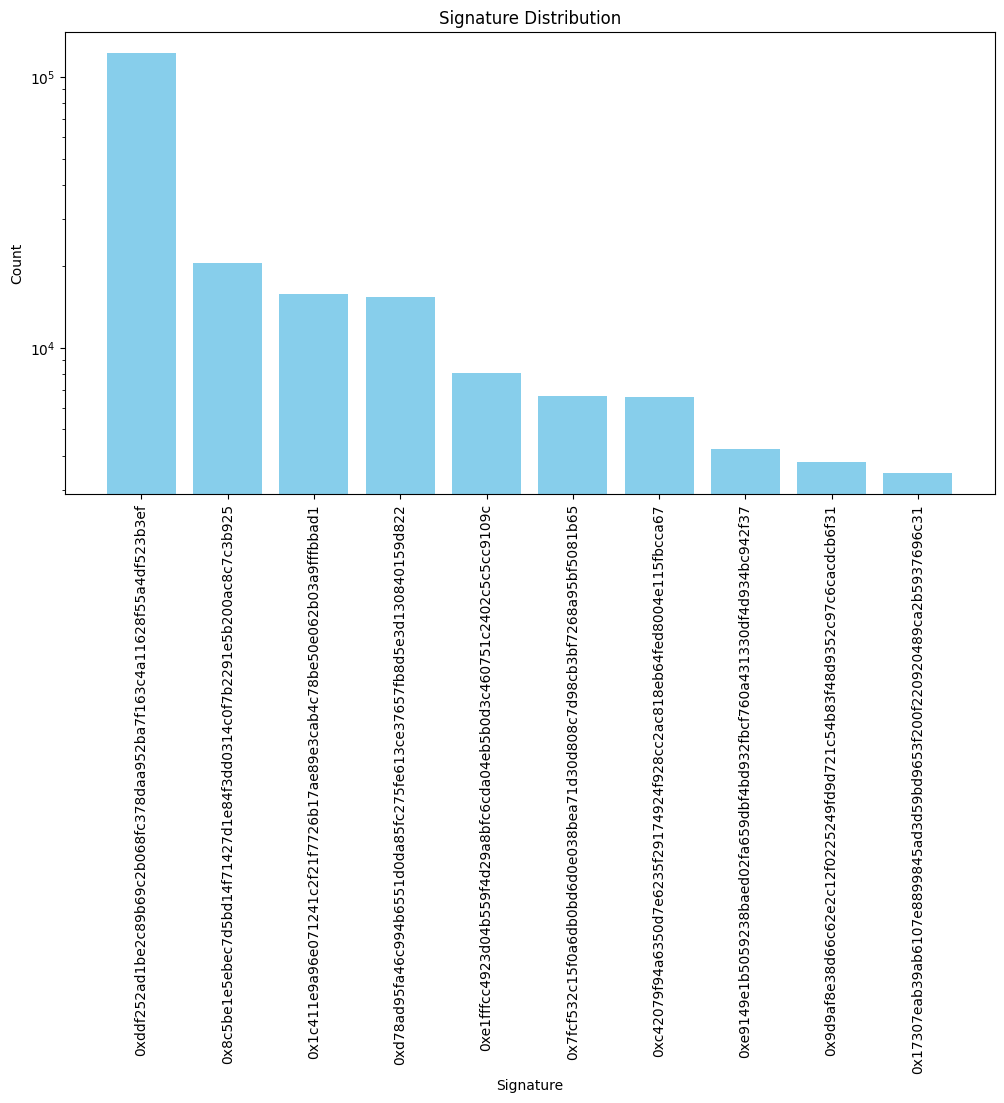

In [37]:
top_normal_signatures = dict(normal_combined_counter.most_common(10))
plot_signature_distribution(top_normal_signatures)

In [41]:
top_normal_signatures

{'0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef': 122464,
 '0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925': 20569,
 '0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78be50e062b03a9fffbbad1': 15749,
 '0xd78ad95fa46c994b6551d0da85fc275fe613ce37657fb8d5e3d130840159d822': 15411,
 '0xe1fffcc4923d04b559f4d29a8bfc6cda04eb5b0d3c460751c2402c5c5cc9109c': 8100,
 '0x7fcf532c15f0a6db0bd6d0e038bea71d30d808c7d98cb3bf7268a95bf5081b65': 6620,
 '0xc42079f94a6350d7e6235f29174924f928cc2ac818eb64fed8004e115fbcca67': 6609,
 '0xe9149e1b5059238baed02fa659dbf4bd932fbcf760a431330df4d934bc942f37': 4227,
 '0x9d9af8e38d66c62e2c12f0225249fd9d721c54b83f48d9352c97c6cacdcb6f31': 3780,
 '0x17307eab39ab6107e8899845ad3d59bd9653f200f220920489ca2b5937696c31': 3452}

In [42]:
top_signatures

{'0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef': 537882,
 '0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78be50e062b03a9fffbbad1': 211626,
 '0xd78ad95fa46c994b6551d0da85fc275fe613ce37657fb8d5e3d130840159d822': 211143,
 '0xc42079f94a6350d7e6235f29174924f928cc2ac818eb64fed8004e115fbcca67': 122189,
 '0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925': 6333,
 '0x7fcf532c15f0a6db0bd6d0e038bea71d30d808c7d98cb3bf7268a95bf5081b65': 5724,
 '0x19b47279256b2a23a1665c810c8d55a1758940ee09377d4f8d26497a3577dc83': 4852,
 '0x908fb5ee8f16c6bc9bc3690973819f32a4d4b10188134543c88706e0e1d43378': 4535,
 '0xddac40937f35385a34f721af292e5a83fc5b840f722bff57c2fc71adba708c48': 4308,
 '0x8201aa3f00000000000000000000000000000000000000000000000000000000': 3513}

In [48]:
print(top_normal_signatures.keys())
print(top_signatures.keys())

dict_keys(['0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef', '0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925', '0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78be50e062b03a9fffbbad1', '0xd78ad95fa46c994b6551d0da85fc275fe613ce37657fb8d5e3d130840159d822', '0xe1fffcc4923d04b559f4d29a8bfc6cda04eb5b0d3c460751c2402c5c5cc9109c', '0x7fcf532c15f0a6db0bd6d0e038bea71d30d808c7d98cb3bf7268a95bf5081b65', '0xc42079f94a6350d7e6235f29174924f928cc2ac818eb64fed8004e115fbcca67', '0xe9149e1b5059238baed02fa659dbf4bd932fbcf760a431330df4d934bc942f37', '0x9d9af8e38d66c62e2c12f0225249fd9d721c54b83f48d9352c97c6cacdcb6f31', '0x17307eab39ab6107e8899845ad3d59bd9653f200f220920489ca2b5937696c31'])
dict_keys(['0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef', '0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78be50e062b03a9fffbbad1', '0xd78ad95fa46c994b6551d0da85fc275fe613ce37657fb8d5e3d130840159d822', '0xc42079f94a6350d7e6235f29174924f928cc2ac818eb64fed8004e115fbcca67

In [45]:
top_keys1 = {key for key, _ in top_signatures.items()}
top_keys2 = {key for key, _ in top_normal_signatures.items()}
overlap = top_keys1.intersection(top_keys2)
overlap

{'0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78be50e062b03a9fffbbad1',
 '0x7fcf532c15f0a6db0bd6d0e038bea71d30d808c7d98cb3bf7268a95bf5081b65',
 '0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925',
 '0xc42079f94a6350d7e6235f29174924f928cc2ac818eb64fed8004e115fbcca67',
 '0xd78ad95fa46c994b6551d0da85fc275fe613ce37657fb8d5e3d130840159d822',
 '0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'}

- 0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef: Transfer (ERC20)
- 0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78be50e062b03a9fffbbad1: Sync
- 0xd78ad95fa46c994b6551d0da85fc275fe613ce37657fb8d5e3d130840159d822: Swap (Uniswap V2)
- 0xc42079f94a6350d7e6235f29174924f928cc2ac818eb64fed8004e115fbcca67: Swap (Uniwswap V3)
- 0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925: Approval
- 0x7fcf532c15f0a6db0bd6d0e038bea71d30d808c7d98cb3bf7268a95bf5081b65: Withdrawal
- 0x8201aa3f00000000000000000000000000000000000000000000000000000000: swapExactAmountIn(address,uint256,address,uint256,uint256)